In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [1]:
from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from docking_analysis import *

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
from detect_intermediates import *
from interpret_tICs import *

we are operating on biox3


In [3]:
from b2ar_feature_types import *
from get_variable_names import *
from b2ar_tica_config import *
from residue import Residue, Atom

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

#set_palette('Set1', n_colors=15, desat=None)

In [5]:
ori_feature_name = copy.deepcopy(feature_name)

In [6]:
schemes = ['closest-heavy']
#schemes = ["closest-heavy", "CA"]
#feature_name = "%s-CA" %ori_feature_name

In [7]:
rho = 0.01
rho_string = "_rho0pt01"
n_clusters=25
n_samples=5
precision = "XP"
lag_time=5

In [8]:
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
ori_tica_dir = copy.deepcopy(tica_dir)
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dirdir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A
/home/enf/b2ar_analysis/featuresall_residues_2rh1_3sn6_under_cutoff6A


In [9]:
tica_dir

'/home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01'

In [10]:
if not os.path.exists(features_dir): os.makedirs(features_dir)
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
featurize_contacts_custom(traj_dir, features_dir = features_dir, 
                          traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, 
                          structures = [active_ref_dir, inactive_ref_dir],  
                          contact_residues =  contact_residues, residues_map = None, 
                          contact_cutoff = 0.66, parallel = False, 
                          exacycle = exacycle, load_from_file=False, schemes=[])


already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already featurized
already feat

In [ ]:
fit_normalizer(features_dir)
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True)

In [10]:
tica_object = verboseload(projection_operator_dir)
print(tica_object.timescales_)

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_tica_coords.h5"...
[ 729.62933227  289.65120394]


Interpreting tIC 1
feature_importances_df.shape
(6, 5)
residue_importances_df.shape
(11, 2)
       feature_name   res_i   res_j  importance           feature
3  Phe108 To Gln170  Phe108  Gln170    0.278917  PHE108 to GLN170
5  Thr274 To Cys327  Thr274  Cys327   -0.216950  THR274 to CYS327
0   Asn51 To Ser319   Asn51  Ser319    0.209493   ASN51 to SER319
4   Asp79 To Tyr326   Asp79  Tyr326    0.195303   ASP79 to TYR326
2   Leu75 To Pro323   Leu75  Pro323   -0.172376   LEU75 to PRO323
1   Asn51 To Gly320   Asn51  Gly320   -0.163539   ASN51 to GLY320
Using dark_background


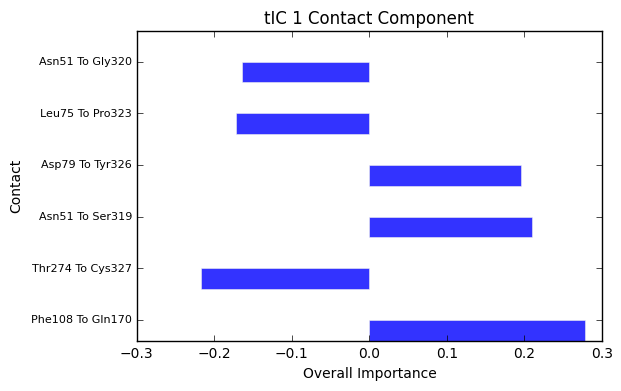

       residue  importance
Gln170  Gln170    0.278917
Phe108  Phe108    0.278917
Cys327  Cys327   -0.216950
Thr274  Thr274   -0.216950
Ser319  Ser319    0.209493
Tyr326  Tyr326    0.195303
Asp79    Asp79    0.195303
Asn51    Asn51    0.190841
Pro323  Pro323   -0.172376
Leu75    Leu75   -0.172376
Gly320  Gly320   -0.163539
Using dark_background


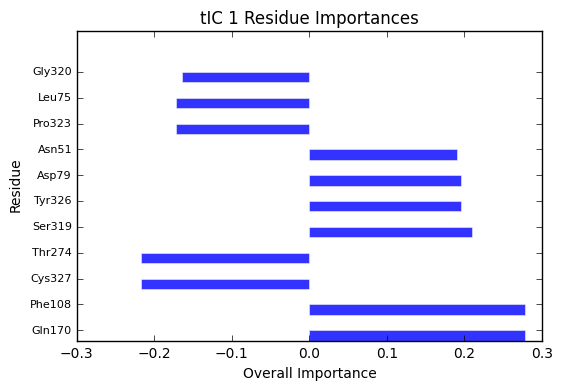

Interpreting tIC 2
feature_importances_df.shape
(7, 5)
residue_importances_df.shape
(12, 2)
       feature_name   res_i   res_j  importance           feature
6  Tyr219 To Leu272  Tyr219  Leu272    0.442840  TYR219 to LEU272
2   Asp79 To Tyr326   Asp79  Tyr326    0.325170   ASP79 to TYR326
3  Ile127 To Leu275  Ile127  Leu275    0.305118  ILE127 to LEU275
4  Tyr141 To Glu268  Tyr141  Glu268    0.272796  TYR141 to GLU268
0   Asp79 To Asn318   Asp79  Asn318    0.257021   ASP79 to ASN318
5  Tyr219 To Ala271  Tyr219  Ala271   -0.205418  TYR219 to ALA271
1   His93 To Cys190   His93  Cys190    0.193080   HIS93 to CYS190
Using dark_background


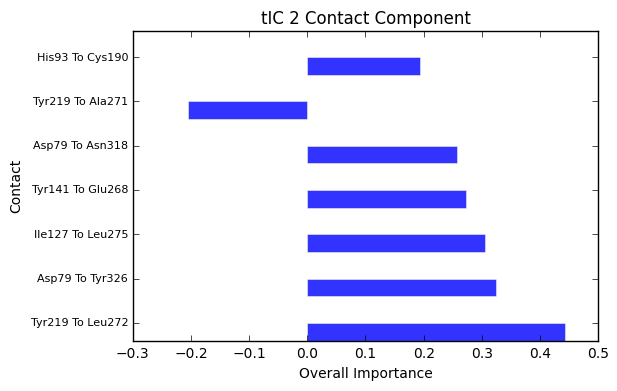

       residue  importance
Leu272  Leu272    0.442840
Tyr219  Tyr219    0.410427
Tyr326  Tyr326    0.325170
Asp79    Asp79    0.321762
Leu275  Leu275    0.305118
Ile127  Ile127    0.305118
Glu268  Glu268    0.272796
Tyr141  Tyr141    0.272796
Asn318  Asn318    0.257021
Ala271  Ala271   -0.205418
Cys190  Cys190    0.193080
His93    His93    0.193080
Using dark_background


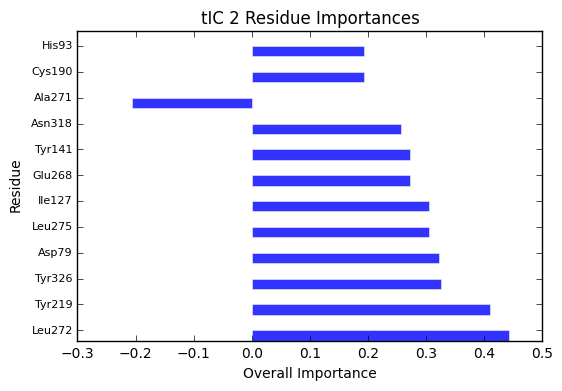

In [11]:
tic_components_dir = tica_dir
important_contact_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, feature_residues_pkl, n_tica_components=n_components, percentile=95)

In [12]:
tica_coords = verboseload(projected_features_dir)
pnas_coords = verboseload(pnas_coords_dir)
for pnas_coord in pnas_coords: pnas_coord[:,0]*=7.14
tica_names = ["tIC.%d" %i for i in range(1,n_components+1)]
pnas_names = ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/b2ar_analysis/all_pnas_features/pnas_coords.h5"...


In [14]:
cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters=n_clusters, clusterer_dir=clusterer_dir)

loading /home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_25clusters.h5"...
Saving "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_25clusters.h5"... (<class 'msmbuilder.cluster.MiniBatchKMeans'>)


In [15]:
docking_dir

'/home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/docking_n_clusters25_n_samples5_random_XP'

In [13]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

samples_indices_file = "%s/samples_indices.h5" %analysis_dir
samples_dir = "%s/clusterer_%dclusters_%dsamples" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir):
    os.makedirs(samples_dir)
#sample_from_clusterer(clusterer_dir, projected_features_dir, get_trajectory_files(traj_dir, ".h5"), 
#                      n_samples, samples_dir, samples_indices_file, structure=None,
#                      residue_cutoff=10000, parallel=True,
#                      worker_pool=None)
clusters_map = make_clusters_map(verboseload(clusterer_dir))

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_25clusters.h5"...
60556
18142
29602
11692
9005
39876
6361
47042
42043
15117
42889
14554
7263
45472
23113
25186
24422
14847
41130
11930
8705
10899
21655
16763
11754


In [19]:
 def calculate_cluster_averages_per_feature(clusterer, features):
  n_clusters = clusterer.n_clusters 
  concatenated_clusters = np.concatenate(clusterer.labels_)
  concatenated_features = np.concatenate(features)
  cluster_averages = np.zeros((n_clusters, concatenated_features.shape[1]))
  for i in range(0, n_clusters):
    rows = np.where(concatenated_clusters == i)[0]
    means = np.mean(concatenated_features[rows,:], axis=0)
    cluster_averages[i,:] = means
  return cluster_averages

In [20]:
clusterer = verboseload(clusterer_dir)
cluster_averages = calculate_cluster_averages_per_feature(clusterer, pnas_coords)

loading "/home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_25clusters.h5"...


In [ ]:
plt.scatter(cluster_averages[:,0], cluster_averages[:,2])

In [21]:
cluster_averages = pd.DataFrame(cluster_averages, columns=pnas_names)
active_clusters = cluster_averages.loc[(cluster_averages["rmsd_npxxy_active"] < 0.5) & (cluster_averages["tm6_tm3_dist"] > 12.) & (cluster_averages["tm6_tm3_dist"] < 15.)]
inactive_clusters = cluster_averages.loc[(cluster_averages["rmsd_npxxy_active"] > 0.5) & (cluster_averages["tm6_tm3_dist"] <10.)]

In [22]:
active_clusters

,tm6_tm3_dist,rmsd_npxxy_inactive,rmsd_npxxy_active,rmsd_connector_inactive,rmsd_connector_active


In [ ]:
import plots
reload(plots)
from plots import *

In [ ]:
plot_data_vs_data(np.concatenate(tica_coords), np.concatenate(pnas_coords), tica_names, pnas_names, analysis_dir)

In [ ]:
analysis_dir

In [ ]:
plot_columns(tica_dir, projected_features_dir, titles = ["tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

In [ ]:
get_ligands(agonist_dir)

In [ ]:
get_ligands(biased_agonist_dir)

In [ ]:
docking_multiple_ligands

In [14]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))



273


<AsyncMapResult: chdir>

In [ ]:
user_defined_features_file

In [ ]:
import b2ar_feature_types
reload(b2ar_feature_types)
from b2ar_feature_types import *

import analysis
reload(analysis)
from analysis import *

import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *

compute_user_defined_features_wrapper(traj_dir, traj_ext, inactive_dir, active_dir, None,
                                        feature_name_residues_dict, user_defined_features_file, worker_pool=None, 
                                        parallel=False)

In [ ]:
import grids
reload(grids)
from grids import *

grid_center = "64.4, 16.9, 11.99"


indices = [0,25]
chosen_receptors = []
for i in range(indices[0], indices[1]):
  for j in range(0, n_samples):
    chosen_receptors.append("cluster%d_sample%d" %(i, j))

biased_ligands = get_ligands(biased_agonist_dir)
print("biased_ligands")
print(biased_ligands)
reimaged_dir = samples_dir
mae_dir = reimaged_dir
#remove_ter(reimaged_dir)
#reorder(reimaged_dir)

inverse_ligands = get_ligands(inverse_agonist_dir)
agonist_ligands = get_ligands(agonist_dir)

mehrdad_dir = "%s/mehrdad_ligands" %agonist_dir
all_ligands_dir = "/home/enf/b2ar_analysis/all_ligands"


#agonist_ligands = [a for a in agonist_ligands if "TA" not in a]

#pprep(mae_dir, ref = active_ref_dir, chosen_receptors = chosen_receptors, worker_pool=None, parallel=True)
generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors = chosen_receptors, worker_pool=None, outer_box=25.)
dock_ligands_and_receptors(grid_dir, docking_dir, all_ligands_dir, precision = precision, ext = "-out.maegz", chosen_ligands = False, chosen_receptors = False, parallel = False, grid_ext = ".zip", worker_pool=dview)

#dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)



biased_ligands
['', '', '', 'isoetharine', 'isoetharine_prepped', 'nebivolol', 's-carvedilol', 's-carvedilol_prepped', 'salmeterol', 'xamoterol']
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/grids_n_clusters25_n_samples5_random
$SCHRODINGER/run $SCHRODINGER/mmshare-v3.3/python/common/delete_atoms.py -asl "res.pt BIA " /home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/clusterer_25clusters_5samples/cluster0_sample0.mae /home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/grids_n_clusters25_n_samples5_random/cluster0_sample0.mae
$SCHRODINGER/run $SCHRODINGER/mmshare-v3.3/python/common/delete_atoms.py -asl "res.pt BIA " /home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_r

In [ ]:
t = md.load("/home/enf/b2ar_analysis/subsampled_reimaged_amber/C-02.h5")
top = t.topology

In [ ]:
[(c.id, c.n_residues) for c in t.topology.chains]

In [27]:
import analysis
reload(analysis)
from analysis import *

docking_results = analyze_docking_results_multiple(docking_dir, precision = "XP", ligands = get_trajectory_files(all_ligands_dir), summary = docking_multiple_ligands, redo = True)
c = compute_cluster_averages(None, csv_filename=docking_multiple_ligands, save_csv=aggregate_docking)

#compute_aggregate_scores(docking_multiple_ligands, inverse_agonists = inverse_ligands, summary = aggregate_docking, z_scores_csv = docking_z_scores_csv)
#aggregate_docking_joined_map = convert_csv_to_joined_map(aggregate_docking, aggregate_docking_joined)[0]
#aggregate_docking_means = calc_mean(aggregate_docking_joined_map)
#write_map_to_csv(aggregate_docking_joined, aggregate_docking_means, ["cluster", "mean_aggregate_docking_z_score"])
#r['do.analysis'](tica_dir, analysis_dir, pnas_coords_csv, tica_coords_csv, features_dir, docking_multiple_ligands)
#tics_vs_docking_file = "%s/tICA_vs_docking.pdf" % analysis_dir
#plot_tICs_vs_docking(docking_multiple_ligands, tica_coords_csv, tics_vs_docking_file, chosen_ligand="s-carvedilol")


Analyzing docking results
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/docking_n_clusters25_n_samples5_random_XP
[]
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/docking_n_clusters25_n_samples5_random_XP/olodaterol
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/docking_n_clusters25_n_samples5_random_XP/s-carvedilol
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/docking_n_clusters25_n_samples5_random_XP/s-carazolol
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components2all_residues_2rh1_3sn6_under_cutoff6A_regularization_wolf_autoShrinkage_rho0pt01/docking_n_clusters25_n_samples5_random_XP/pindolol
/home/enf/b2ar_analysis/sparse-tICA_t5_n_components

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


currently analyzing s-carvedilol
currently analyzing s-carazolol
currently analyzing pindolol
currently analyzing ah3474
currently analyzing nadolol
currently analyzing ritrodine
currently analyzing acebutolol
currently analyzing Ici118551
currently analyzing practolol
currently analyzing norepinephrine
currently analyzing s-atenolol
currently analyzing formoterol
currently analyzing MAPE
currently analyzing fenoterol
currently analyzing cicloprolol
currently analyzing ZINC_results-single
currently analyzing clenproperol
currently analyzing r_epinephrine
currently analyzing Ici215001
currently analyzing Tulobuterol
currently analyzing pronethalol
currently analyzing du28663
currently analyzing 3p0g_lig
currently analyzing sotalol
currently analyzing timolol
currently analyzing N-Cyclopentylbutanephrine
currently analyzing metoprolol
currently analyzing orciprenaline
currently analyzing labetalol
currently analyzing cimaterol
currently analyzing terbutaline
currently analyzing TERBSN
cu

In [ ]:
lag_time = 25
msm_model_dir = "%s/msm_lag_time%d.h5" % (tica_dir, lag_time)
build_msm(clusterer_dir, lag_time=lag_time, msm_model_dir=msm_model_dir)


In [ ]:
n_clusters = 100
n_samples=5

clusterer_tICs_1_2_3_filename = "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples.h5" %(tica_dir, n_clusters, n_samples)
clusterer_tICs_1_2_3_map_file = "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_map.json" %(tica_dir, n_clusters, n_samples)
tics_to_cluster = [0, 1, 2]

projected_features_tICs_1_2_3_filename = "%s/projected_features_tICs_1_2_3.h5" %tica_dir
projected_features = verboseload(projected_features_dir)
projected_features = [f[:, [0, 1, 2]] for f in projected_features]
verbosedump(projected_features, projected_features_tICs_1_2_3_filename)

cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters=n_clusters, clusterer_dir=clusterer_tICs_1_2_3_filename, tICs=tics_to_cluster)
clusterer_tICs_1_2_3 = verboseload(clusterer_tICs_1_2_3_filename)
clusterer_tICs_1_2_3_map = make_clusters_map(clusterer_tICs_1_2_3)
samples_dir = "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_samples" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)


In [68]:
samples_dir = "/home/enf/b2ar_analysis/reference_receptors"
grid_dir = "/home/enf/b2ar_analysis/reference_grids"
docking_dir = "/home/enf/b2ar_analysis/reference_docking/docking_XP"

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

import custom_msm
reload(custom_msm)
from custom_msm import *

samples_dir = "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)

#sample_from_clusterer(clusterer_tICs_1_2_3_filename, projected_features_tICs_1_2_3_filename, get_trajectory_files(traj_dir, traj_ext), 
#                      n_samples, samples_dir, samples_indices_file,
#                      worker_pool=None, parallel=False)


In [ ]:
clusterer_tICs_1_2_3_samples = {}
with open(clusters_map_file) as f:
    clusterer_samples = json.load(f)
    clusterer_samples = {int(k):[tuple(vi[0:2]) for vi in v] for k,v in list(clusterer_samples.items())}
#print(clusterer_samples)
original_samples = set()
for key, sample_list in clusterer_samples.iteritems():
    for sample in sample_list:
        original_samples.add(sample)
#print(original_samples)
for cluster_id, sample_list in clusterer_tICs_1_2_3_map.iteritems():
    if cluster_id not in clusterer_tICs_1_2_3_samples.keys():
        clusterer_tICs_1_2_3_samples[cluster_id] = []
    for sample in sample_list:
        if sample in original_samples:
            clusterer_tICs_1_2_3_samples[cluster_id].append(sample)

In [ ]:
grid_center = "64.4, 16.9, 11.99"

indices = [0,n_clusters]
chosen_receptors = []
for i in range(indices[0], indices[1]):
  for j in range(0, n_samples):
    chosen_receptors.append("cluster%d_sample%d" %(i, j))
#print(chosen_receptors)
biased_ligands = get_ligands(biased_agonist_dir)
#print("biased_ligands")
#print(biased_ligands)
reimaged_dir = samples_dir
mae_dir = reimaged_dir
#remove_ter(reimaged_dir)
#reorder(reimaged_dir)

mehrdad_dir = "%s/mehrdad_ligands" %agonist_dir


grid_dir =  "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_kdtree_grids" %(tica_dir, n_clusters, n_samples)
docking_dir =  "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_kdtree_docking" %(tica_dir, n_clusters, n_samples)

#prepare_ligands(inverse_agonist_dir, [".sdf"])
#prepare_ligands(agonist_dir, [".sdf"])

agonist_ligands = get_ligands(agonist_dir)
inverse_ligands = get_ligands(inverse_agonist_dir)


#print(mehrdad_dir)
mehrdad_ligands = get_ligands(mehrdad_dir)
#print("Mehrdad ligands:")
#print(mehrdad_ligands)

#pprep(mae_dir, ref = active_ref_dir, chosen_receptors = chosen_receptors, worker_pool=None, parallel=True)
#generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors = chosen_receptors, worker_pool=dview)
#unzip_receptors(grid_dir, chosen_receptors, worker_pool=dview)

dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)



#agonist_ligands = [a for a in get_ligands(agonist_dir) if "ta" not in a and "TA" not in a]
#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
dock_ligands_and_receptors(grid_dir, docking_dir, mehrdad_dir, precision = precision, ext = "-out.maegz", chosen_ligands = False, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
dock_ligands_and_receptors(grid_dir, docking_dir, inverse_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = inverse_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)








In [ ]:
grid_center = "64.4, 16.9, 11.99"

indices = [0,n_clusters]
chosen_receptors = []
for i in range(indices[0], indices[1]):
  for j in range(0, n_samples):
    chosen_receptors.append("cluster%d_sample%d" %(i, j))
#print(chosen_receptors)
biased_ligands = get_ligands(biased_agonist_dir)
#print("biased_ligands")
#print(biased_ligands)
reimaged_dir = samples_dir
mae_dir = reimaged_dir
#remove_ter(reimaged_dir)
#reorder(reimaged_dir)

mehrdad_dir = "%s/mehrdad_ligands" %agonist_dir


#grid_dir =  "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_kdtree_grids" %(tica_dir, n_clusters, n_samples)
#docking_dir =  "%s/clusterer_tICs_1_2_3_%dclusters_%dsamples_kdtree_docking" %(tica_dir, n_clusters, n_samples)

#prepare_ligands(inverse_agonist_dir, [".sdf"])
#prepare_ligands(agonist_dir, [".sdf"])

agonist_ligands = get_ligands(agonist_dir)
inverse_ligands = get_ligands(inverse_agonist_dir)


#print(mehrdad_dir)
mehrdad_ligands = get_ligands(mehrdad_dir)
#print("Mehrdad ligands:")
#print(mehrdad_ligands)

#pprep(mae_dir, ref = active_ref_dir, chosen_receptors = chosen_receptors, worker_pool=None, parallel=True)
#generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors = chosen_receptors, worker_pool=dview)
#unzip_receptors(grid_dir, chosen_receptors, worker_pool=dview)

dock_ligands_and_receptors(grid_dir, docking_dir, mehrdad_dir, precision = precision, ext = "-out.maegz", chosen_ligands = mehrdad_ligands, chosen_receptors = False, parallel = "ligand", grid_ext = ".zip", worker_pool=None)


dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = False, parallel = "ligand", grid_ext = ".zip", worker_pool=None)
dock_ligands_and_receptors(grid_dir, docking_dir, biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = False, parallel = "ligand", grid_ext = ".zip", worker_pool=None)




#agonist_ligands = [a for a in get_ligands(agonist_dir) if "ta" not in a and "TA" not in a]
#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = False, parallel = "ligand", grid_ext = ".zip", worker_pool=None)

dock_ligands_and_receptors(grid_dir, docking_dir, inverse_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = inverse_ligands, chosen_receptors = False, parallel = "ligand", grid_ext = ".zip", worker_pool=None)










In [ ]:
docking_multiple_ligands = "%s/all_docking_scores.csv" % docking_dir
aggregate_docking = "%s/aggregate_docking.csv" % docking_dir

analyze_docking_results_multiple(docking_dir, precision = "SP", ligands = biased_ligands + agonist_ligands, summary = docking_multiple_ligands, redo = True)
compute_cluster_averages(None, csv_filename=docking_multiple_ligands, save_csv=aggregate_docking)


In [ ]:
df_agg = pd.read_csv(aggregate_docking)
aggs = df_agg.sort([' nebivolol'], ascending=[0])
aggs.iloc[0:10]
ranked = aggs.rank(axis=0, method='average', ascending=False)

In [ ]:
ranked.iloc[0:10]

In [ ]:
dock_ligands_and_receptors(grid_dir, docking_dir, inverse_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = inverse_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)

In [ ]:
n_clusters = 500
n_samples=10

clusterer_tICs_1_2_3_4_filename = "%s/clusterer_tICs_1_2_3_4_%dclusters_%dsamples.h5" %(tica_dir, n_clusters, n_samples)
clusterer_tICs_1_2_3_4_map_file = "%s/clusterer_tICs_1_2_3_4_%dclusters_%dsamples_map.json" %(tica_dir, n_clusters, n_samples)
tics_to_cluster = [0, 1, 2, 3]


cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters=n_clusters, clusterer_dir=clusterer_tICs_1_2_3_4_filename, tICs=tics_to_cluster)
clusterer_tICs_1_2_3_4 = verboseload(clusterer_tICs_1_2_3_4_filename)
clusterer_tICs_1_2_3_4_map = make_clusters_map(clusterer_tICs_1_2_3_4)
samples_dir = "%s/clusterer_tICs_1_2_3_4_%dclusters_%dsamples_samples" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
#sample_clusters(clusterer_tICs_1_2_3_4_filename, projected_features_dir, traj_dir, traj_ext, save_dir=samples_dir, n_samples=n_samples, method = sampling_method, clusters_map_file = clusterer_tICs_1_2_3_4_map_file, tICs=[0, 1, 2, 3], worker_pool=dview)



In [ ]:
grid_center = "64.4, 16.9, 11.99"

indices = [0,n_clusters]
chosen_receptors = []
for i in range(indices[0], indices[1]):
  for j in range(0, n_samples):
    chosen_receptors.append("cluster%d_sample%d" %(i, j))

biased_ligands = get_ligands(biased_agonist_dir)
print("biased_ligands")
print(biased_ligands)
reimaged_dir = samples_dir
mae_dir = reimaged_dir
#remove_ter(reimaged_dir)
#reorder(reimaged_dir)

inverse_ligands = get_ligands(inverse_agonist_dir)
agonist_ligands = get_ligands(agonist_dir)
mehrdad_dir = "%s/mehrdad_ligands" %agonist_dir

agonist_ligands = [a for a in agonist_ligands]

grid_dir =  "%s/clusterer_tICs_1_2_3_4_%dclusters_%dsamples_grids" %(tica_dir, n_clusters, n_samples)
docking_dir =  "%s/clusterer_tICs_1_2_3_4_%dclusters_%dsamples_docking" %(tica_dir, n_clusters, n_samples)

#prepare_ligands(mehrdad_dir, [".mol"])
#prepare_ligands(agonist_dir, [".sdf"])
print(mehrdad_dir)
mehrdad_ligands = get_ligands(mehrdad_dir)
print("Mehrdad ligands:")
print(mehrdad_ligands)

#pprep(mae_dir, ref = active_ref_dir, chosen_receptors = chosen_receptors, worker_pool=dview)
#generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors = chosen_receptors, worker_pool=dview)
#unzip_receptors(grid_dir, chosen_receptors, worker_pool=dview)

dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)

#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)

agonist_ligands = [a for a in get_ligands(agonist_dir) if "ta" not in a and "TA" not in a]
#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
#inverse_ligands = [lig for lig in inverse_ligands if "carazolol" in lig]
dock_ligands_and_receptors(grid_dir, docking_dir,  inverse_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = inverse_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
dock_ligands_and_receptors(grid_dir, docking_dir, mehrdad_dir, precision = precision, ext = "-out.maegz", chosen_ligands = False, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)







In [ ]:
#### n_clusters = 25
n_samples=100
"""
clusterer_tICs_1_2_filename = "%s/clusterer_tICs_1_2_%dclusters_%dsamples.h5" %(tica_dir, n_clusters, n_samples)
clusterer_tICs_1_2_map_file = "%s/clusterer_tICs_1_2_%dclusters_%dsamples_map.json" %(tica_dir, n_clusters, n_samples)
tics_to_cluster = [0, 1]


cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters=n_clusters, clusterer_dir=clusterer_tICs_1_2_filename, tICs=tics_to_cluster)
clusterer_tICs_1_2 = verboseload(clusterer_tICs_1_2_filename)
clusterer_tICs_1_2_map = make_clusters_map(clusterer_tICs_1_2)
samples_dir = "%s/clusterer_tICs_1_2_%dclusters_%dsamples_samples" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
"""
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *
sample_clusters(clusterer_tICs_1_2_filename, projected_features_dir, traj_dir, traj_ext, save_dir=samples_dir, n_samples=n_samples, method = sampling_method, clusters_map_file = clusterer_tICs_1_2_map_file, tICs=[0, 1], worker_pool=None)



In [ ]:
len(rc.ids)

In [ ]:
indices = [0,n_clusters]
chosen_receptors = []
for i in range(indices[0], indices[1]):
  for j in range(0, n_samples):
    chosen_receptors.append("cluster%d_sample%d" %(i, j))

biased_ligands = get_ligands(biased_agonist_dir)
print("biased_ligands")
print(biased_ligands)
reimaged_dir = samples_dir
mae_dir = reimaged_dir
remove_ter(reimaged_dir)
reorder(reimaged_dir)

inverse_ligands = get_ligands(inverse_agonist_dir)
agonist_ligands = get_ligands(agonist_dir)

agonist_ligands = [a for a in agonist_ligands if "TA" not in a and "ta" not in a]
print(agonist_ligands)

grid_dir =  "%s/clusterer_tICs_1_2_%dclusters_%dsamples_grids" %(tica_dir, n_clusters, n_samples)
docking_dir =  "%s/clusterer_tICs_1_2_%dclusters_%dsamples_docking" %(tica_dir, n_clusters, n_samples)

pprep(mae_dir, ref = active_ref_dir, chosen_receptors = chosen_receptors, worker_pool=dview)
generate_grids(mae_dir, grid_center, grid_dir, remove_lig = "BIA", chosen_receptors = chosen_receptors, worker_pool=dview)
unzip_receptors(grid_dir, chosen_receptors, worker_pool=dview)

dock_ligands_and_receptors(grid_dir, docking_dir,  biased_agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = biased_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)
dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)

#dock_ligands_and_receptors(grid_dir, docking_dir, agonist_dir, precision = precision, ext = "-out.maegz", chosen_ligands = agonist_ligands, chosen_receptors = chosen_receptors, parallel = None, grid_ext = ".grd", worker_pool=dview)



In [ ]:
graph_file = "%s/msm_lag_time%d_graph.graphml" % (tica_dir, lag_time)
construct_graph(msm_model_dir, clusterer_dir, n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None)


In [ ]:
from imp import reload
import custom_msm
reload(custom_msm)
from custom_msm import *
msm_file = msm_model_dir
sampled_frames_file = "%s/msm100_frames.h5" %tica_dir
msm_trajectory_filename = "%s/msm100_1000frames" %tica_dir
make_msm_trajectory(msm_file, projected_features_dir, traj_dir, sampled_frames_file, clusterer_dir, msm_trajectory_filename, 
                    n_clusters, start_cluster=22, n_steps=1000)

In [ ]:
mytraj = md.load("/home/amir/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/rep_1.h5")

In [ ]:
dir(mytraj)

In [ ]:
del mytraj

In [ ]:
subset = crystal_structure.atom_slice(range(0,400))
subset.xyz
print(subset.xyz)
distances = md.compute_contacts(subset)
print(distances)


In [ ]:
distances0 = distances[0]

In [ ]:
distances0 = np.nan_to_num(distances0)

In [ ]:
distances0

In [ ]:
np.where(distances0 > 0.0)

In [ ]:
from msmbuilder.lumping.pcca_plus import PCCAPlus
n_macrostates = 50
lumper = PCCAPlus(n_macrostates)
msm_obj = verboseload(msm_model_dir)
lumper = lumper.from_msm(msm=msm_obj, n_macrostates=n_macrostates)


In [ ]:
for cluster in inactive_clusters.index.values:
    if cluster in msm_obj.mapping_.keys():
        microstate = msm_obj.mapping_[cluster]
        macrostate = lumper.microstate_mapping_[microstate]
        if macrostate == 8: print(macrostate)